In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [14]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [15]:
train_features=torch.load('train_features.pt')
train_labels=torch.load('train_labels.pt')

In [16]:
print(train_features.shape)
print(train_labels.shape)

torch.Size([1704759, 14])
torch.Size([1704759])


In [17]:
train = torch.cat([train_features, train_labels.reshape(-1,1)],1)
print(train.shape)
train = train[torch.randperm(train.size(0))] #shuffling dataset, parameter down need to be updated
train_set = train[0:1500000,                            0:train.shape[1]-1]
train_label = train[0:1500000,                          train.shape[1]-1]
validation_set = train[1500000:1600000,                 0:train.shape[1]-1]
validation_label = train[1500000:1600000,               train.shape[1]-1]
test_set = train[1600000:train.shape[0],                0:train.shape[1]-1]
test_label = train[1600000:train.shape[0],              train.shape[1]-1]

torch.Size([1704759, 15])


In [62]:
train_set

tensor([[ 0.0000,  0.0000,  8.0000,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000, 12.0000,  ...,  1.0000,  0.0000,  0.0000],
        [-0.5410, -1.9605, 10.0000,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000, 11.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.0912,  0.4009, 11.0000,  ...,  1.0000,  0.0000,  0.0000]])

In [18]:
print(test_set.shape)

torch.Size([104759, 14])


In [19]:
#You may save them if you want
torch.save(train_set,'train_set.pt')
torch.save(train_label,'train_label.pt')
torch.save(validation_set,'validation_set.pt')
torch.save(validation_label,'validation_label.pt')
torch.save(test_set,'test_set.pt')
torch.save(test_label,'test_label.pt')

In [20]:
del train_features
del train_labels

In [21]:
print(train_set.dtype)
print(train_label.dtype)

torch.float32
torch.float32


In [22]:
train_set.shape

torch.Size([1500000, 14])

In [27]:
device

device(type='cuda')

In [28]:
class MLP(nn.Module):
    def __init__(self, input_features, hidden_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_size),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output_layer(x)
        return x


In [29]:
# Number of features in your data and the size of the hidden layer
input_features = train_set.shape[1]
hidden_size = 10

# Initialize the model and move to the device
model = MLP(input_features, hidden_size)
model = model.to(device)


In [35]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y) + self.eps)


In [54]:
import torch.optim as optim
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 5
BATCH_SIZE = 64

In [51]:
train_dataset = TensorDataset(train_set, train_label)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(validation_set, validation_label)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


print(len(train_loader))
all_losses = []

23438


In [53]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():  # We don't need gradients for validation
        for inputs, targets in val_loader:
            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reshape targets
            targets = torch.reshape(targets,(-1,1))

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = torch.sqrt(criterion(outputs, targets))  # RMSE

            # Accumulate loss
            running_val_loss += loss.item()

    # Return average loss
    average_val_loss = running_val_loss / len(val_loader)
    return average_val_loss


In [57]:
def train(model, train_loader, val_loader, criterion, num_epochs):
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        epoch_loss = 0
        group_320_loss = 0
        for i,(x, y) in enumerate(train_loader,0):
            x = x.to(device)
            y = y.to(device)
            y = torch.reshape(y,(-1,1))
            optimizer.zero_grad()
            output = model(x)
            loss = torch.sqrt(criterion(output, y))#RMSE
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            group_320_loss += loss.item()
            if i%30==29:
                all_losses.append(group_320_loss/6)
        print(f"Epoch: {epoch+1} Training Loss:{epoch_loss/len(train_loader)}")

        # Validation Phase
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = torch.reshape(y_val,(-1,1))
                preds = model(x_val)
                val_loss += torch.sqrt(criterion(preds, y_val)).item() # RMSE
        print(f"Epoch: {epoch+1} Validation Loss:{val_loss/len(val_loader)}")




In [63]:
learning_rates = [1e-3, 1e-4, 1e-5]
weight_decays = [1e-3, 1e-4, 1e-5]

best_val_loss = float('inf')
best_hyperparameters = None

for lr in learning_rates:
    for wd in weight_decays:
        print(f"Training with learning rate {lr} and weight decay {wd}")
        model = MLP(train_set.shape[1],10).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        train(model, train_loader, val_loader, criterion, num_epochs) # use the training function you defined
        val_loss = validate(model, val_loader, criterion) # you will need to define a validate function

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hyperparameters = (lr, wd)

print(f"Best validation loss: {best_val_loss}")
print(f"Best hyperparameters: learning rate {best_hyperparameters[0]}, weight decay {best_hyperparameters[1]}")


Training with learning rate 0.001 and weight decay 0.001
Epoch: 1 Training Loss:580.4425179385236
Epoch: 1 Validation Loss:580.8674465186765
Epoch: 2 Training Loss:572.8421654940893
Epoch: 2 Validation Loss:579.6405604698684
Epoch: 3 Training Loss:572.714111680331
Epoch: 3 Validation Loss:579.0455433948637
Epoch: 4 Training Loss:572.0058029068036
Epoch: 4 Validation Loss:580.1433473124538
Epoch: 5 Training Loss:571.8242116036681
Epoch: 5 Validation Loss:579.7281943215671
Training with learning rate 0.001 and weight decay 0.0001
Epoch: 1 Training Loss:582.6103047431864
Epoch: 1 Validation Loss:580.798876351755
Epoch: 2 Training Loss:573.129197310848
Epoch: 2 Validation Loss:581.6621524081044
Epoch: 3 Training Loss:573.0099476549709
Epoch: 3 Validation Loss:580.419062970162
Epoch: 4 Training Loss:572.5350274558726
Epoch: 4 Validation Loss:580.4310192906239
Epoch: 5 Training Loss:572.0992895680205
Epoch: 5 Validation Loss:580.4896173751744
Training with learning rate 0.001 and weight deca

In [34]:
train(model, train_loader,criterion,num_epochs)

Epoch: 1 Loss:2904.1357421875
Epoch: 2 Loss:2864.908447265625
Epoch: 3 Loss:2864.289306640625
Epoch: 4 Loss:2863.82568359375
Epoch: 5 Loss:2860.9482421875
Epoch: 6 Loss:2864.11669921875
Epoch: 7 Loss:2864.02490234375
Epoch: 8 Loss:2862.87548828125
Epoch: 9 Loss:2862.2080078125
Epoch: 10 Loss:2857.65087890625


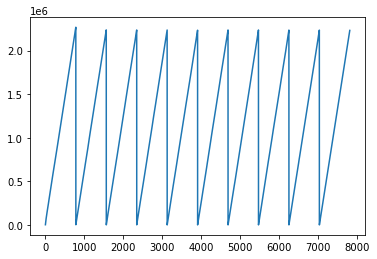

In [36]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

In [37]:
del all_losses

In [38]:
def view_loss(model, test_set, test_label,criterion):
    total_loss=0
    test_dataset = TensorDataset(test_set, test_label)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y = torch.reshape(y,(-1,1))
        output = model(x)
        loss = torch.sqrt(criterion(output, y))#RMSE
        total_loss += loss
    return total_loss

In [ ]:
#You need to see loss for validation set to tune the parameter. I didn't do that because linear regression is too simple

In [39]:
print(view_loss(model, test_set, test_label,criterion)/test_set.shape[0]*320)

tensor(2800.0242, device='cuda:0', grad_fn=<MulBackward0>)


In [40]:
predict_input = torch.load('predict_input.pt').to(device)
print(predict_input.shape)

torch.Size([320, 14])


In [41]:
def predict(model):
    predict_output = model(predict_input)
    return predict_output

In [42]:
out = predict(model)
print(out)

tensor([[688.5222],
        [688.4796],
        [688.5222],
        [688.4948],
        [688.4459],
        [784.9577],
        [688.5222],
        [784.9577],
        [688.4985],
        [688.5222],
        [688.4368],
        [727.5194],
        [727.5194],
        [727.5194],
        [727.5194],
        [727.5194],
        [727.5194],
        [727.5194],
        [688.5222],
        [727.5194],
        [688.5222],
        [784.9577],
        [784.9577],
        [688.5222],
        [688.3863],
        [688.3274],
        [688.5222],
        [688.5222],
        [688.3593],
        [688.5222],
        [688.5222],
        [688.4796],
        [727.5194],
        [727.5194],
        [727.5194],
        [727.5194],
        [784.9577],
        [688.4542],
        [688.5222],
        [688.4938],
        [688.4187],
        [727.5194],
        [727.5194],
        [688.4985],
        [688.4095],
        [688.4854],
        [727.5194],
        [727.5194],
        [688.4526],
        [688.4368],


In [43]:
linear_predict = pd.read_csv('test_public.csv')
linear_predict = linear_predict['TRIP_ID']
predict_tensor = out.to('cpu').detach().numpy().flatten()
linear_predict= pd.concat([linear_predict, pd.DataFrame(predict_tensor)], axis=1)
linear_predict = linear_predict.rename(columns={0: 'TRAVEL_TIME'})
linear_predict.head()

,TRIP_ID,TRAVEL_TIME
0,T1,688.522156
1,T2,688.479553
2,T3,688.522156
3,T4,688.494751
4,T5,688.445862


In [44]:
linear_predict.to_csv('linear_predict.csv', index=False)

In [45]:
PATH = 'linear.pth'
torch.save(model.state_dict(),PATH)

In [49]:
model = MLP(14,20).to(device)
model_state = torch.load('linear.pth')
model.load_state_dict(model_state)

RuntimeError: Error(s) in loading state_dict for MLP:
	size mismatch for layer1.0.weight: copying a param with shape torch.Size([10, 14]) from checkpoint, the shape in current model is torch.Size([20, 14]).
	size mismatch for layer1.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for layer2.0.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for layer2.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for output_layer.weight: copying a param with shape torch.Size([1, 10]) from checkpoint, the shape in current model is torch.Size([1, 20]).

In [ ]:
#Use sklearn for something like gradient boosting or random forest

#Model Selection: Gradient Boosting,Random Forest,Extra Randomized Trees, SVM, Linear Regression, Logistic Regression, Neural Networks

In [ ]:
#TODO: build other models
#TODO: report loss on validation sets and tune parameters for each model
#TODO: run on test sets and report test loss
#TODO: predict travel time(test_features) and submit to kaggle